In [1]:
train = False

In [2]:
# load libraries
import torch
import torch.nn as nn
import torch.optim as optim
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import os


class Discriminator(nn.Module):
    def __init__(self, n_channels, imsize):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            # in_filters, out_filters, kernel, stride, padding
            nn.Conv2d(n_channels,  imsize * 4, 4, 2, 1), # conv1 64x64
            nn.BatchNorm2d(imsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 4, imsize * 8, kernel_size=4, # conv2 I=32x32
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv3 I=16x16
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv4 O=2x2
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv5
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True), # conv6
            nn.Conv2d(imsize * 8, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)





class Generator(nn.Module):
    def __init__(self, latent_size, n_channels, imsize):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_size, imsize * 8, kernel_size=4, #conv1
                               stride=1, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(imsize * 8, imsize * 8, kernel_size=4, #conv2
                               stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(imsize * 8, imsize * 8, kernel_size=4, #conv3
                               stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(imsize * 8, imsize * 4, kernel_size=4, #conv4
                               stride=2, padding=1),
            nn.BatchNorm2d(imsize * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(imsize * 4, imsize * 2,kernel_size=4,#conv5
                               stride=2,padding=1),
            nn.BatchNorm2d(imsize * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(imsize * 2, n_channels, kernel_size=4,#conv6
                               stride=2, padding=1),
            nn.Tanh()

            )
    def forward(self, input):
        return self.net(input)


class GAN():
    def __init__(self, device, save_dir):
        self.generator = None
        self.discriminator = None
        self.save_dir = save_dir
        self.device = device

    def compile(self, latent_size=100, n_channels=3, imsize=64):

        self.latent_size = latent_size
        self.generator = Generator(latent_size, n_channels, imsize).to(self.device)
        self.discriminator = Discriminator(n_channels, imsize).to(self.device)
        dis_learning_rate = 0.0002
        gen_learning_rate = 0.0002
        self.dis_optimizer = optim.Adam(self.discriminator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))
        self.gen_optimizer = optim.Adam(self.generator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))

    def load(self, save_dir):
        self.generator.load_state_dict(torch.load(
                join(save_dir, "generator_state.pt")))
        self.discriminator.load_state_dict(torch.load(
                join(save_dir, "discriminator_state.pt")))
        self.discriminator.eval()
        self.generator.eval()

    def  __call__(self, input):
        self.discriminator.eval()
        self.generator.eval()
        return self.generator(input)

    def train(self, dataloader, n_epochs):

        if self.generator is None:
            raise Exception("Compile the model before training")

        criterion = nn.BCELoss()

        # keep track of progress
        self.G_losses = []
        self.D_losses = []

        for epoch in range(n_epochs):

            for i, data in enumerate(dataloader, 0):
                # load image batch
                image, _ = data
                image = image.to(self.device)
                batch_size = image.size()[0]
                trues = torch.ones([batch_size, 1], device=self.device)
                fakes = torch.zeros([batch_size, 1], device=self.device)




                # TRAIN DISCRIMINATIVE
                # zero grads
                self.dis_optimizer.zero_grad()
                # true batch
                out = self.discriminator(image).view(-1, 1)
                loss_real = criterion(out, trues)
                loss_real.backward(retain_graph=True)
                accuracy_dis = out.mean().item()

                # fake batch
                noise = torch.randn(batch_size, self.latent_size, 1, 1, device=self.device)

                fake = self.generator(noise)
                out = self.discriminator(fake).view(-1, 1)
                loss_fake = criterion(out, fakes)
                loss_fake.backward(retain_graph=True)
                lossD = loss_real + loss_fake
                self.dis_optimizer.step()
                accuracy_gen_1 = out.mean().item()

                # TRAIN GENERATOR
                # zero grads
                self.gen_optimizer.zero_grad()

                out = self.discriminator(fake).view(-1, 1)
                lossG = criterion(out, trues)
                lossG.backward()
                self.gen_optimizer.step()
                accuracy_gen_2 = out.mean().item()

                # PRINT STATS
                if i % 100 == 0:
                    torch.save(self.discriminator.state_dict(),
                               join(self.save_dir, "discriminator_state.pt"))
                    torch.save(self.generator.state_dict(),
                               join(self.save_dir, "generator_state.pt"))
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tAcc_dis: %.4f\tAcc_gen: %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), accuracy_dis, accuracy_gen_1, accuracy_gen_2))

                self.G_losses.append(lossG.item())
                self.D_losses.append(lossD.item())

    def plot(self):
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.G_losses,label="G")
        plt.plot(self.D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda")

imsize = 64
n_channels = 3
latent_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root="resized_CelebA/" , transform=transform)

batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)

In [4]:
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda")
# device = torch.device("cpu")


imsize = 64
n_channels = 3
latent_size = 100

save_dir = "models/GAN/model_states/"


model = GAN(device=device, save_dir=save_dir)
model.compile()

In [5]:
if train:
    n_epochs = 25
    model.train(dataloader, n_epochs)

In [6]:
# load model from file 
load_dir = "models/GAN/model_states/version_0_10e/"
model.load(load_dir)

In [7]:
def display_images(img, figsize=(16,16)):
    fig = plt.figure(figsize=figsize)
    plt.axis("off")
    img_list = [vutils.make_grid(img, padding=2, normalize=True).cpu().detach()]

    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    plt.show()

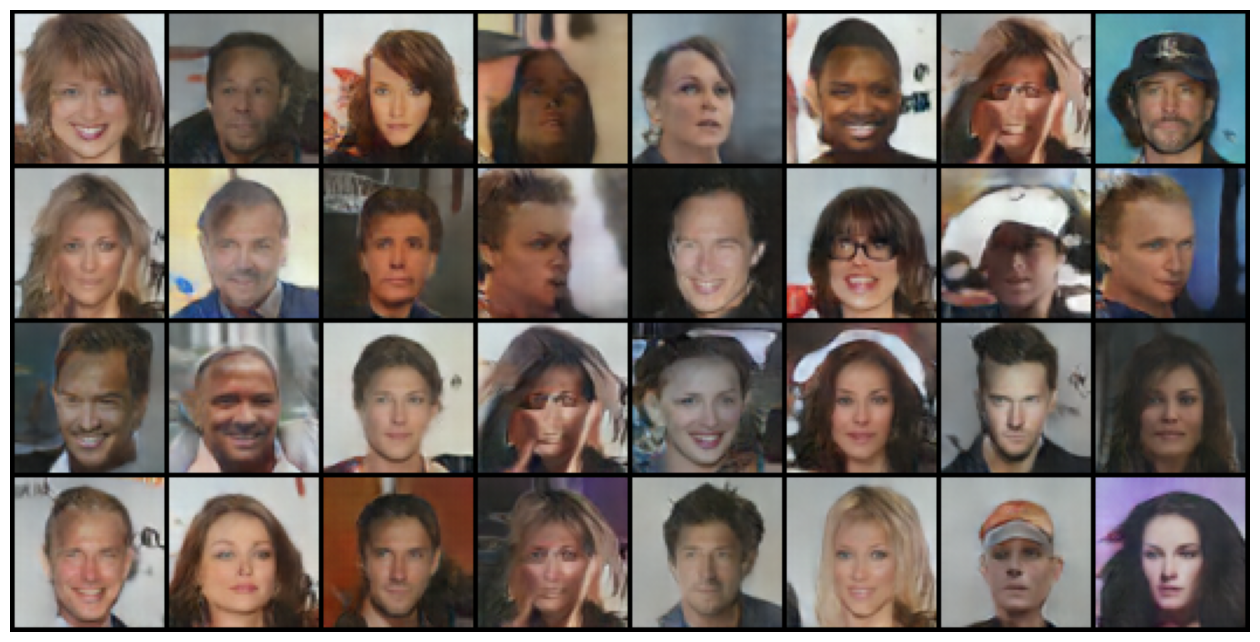

In [8]:
noise = torch.randn(32, 100,1, 1, device=device)
img = model(noise)
display_images(img)

In [9]:
# write an encoder to learn the input image to latent vector mapping for this generator gan
# use the encoder to generate latent vectors for the images in the dataset

class Encoder(nn.Module):
    def __init__(self, latent_size, n_channels, imsize):
        super(Encoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(n_channels,  imsize * 4, 4, 2, 1), # conv1 64x64
            nn.BatchNorm2d(imsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 4, imsize * 8, kernel_size=4, # conv2 I=32x32
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv3 I=16x16
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv4 O=2x2
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(imsize * 8, imsize * 8, kernel_size=4, # conv5
                      stride=2, padding=1),
            nn.BatchNorm2d(imsize * 8),
            nn.LeakyReLU(0.2, inplace=True), # conv6
            nn.Conv2d(imsize * 8, latent_size, 4, 2, 1)
        )

    def forward(self, input):
        return self.net(input)
    


def train_encoder(encoder, generator, dataloader, n_epochs):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.MSELoss()

    for epoch in range(n_epochs):
        for i, data in enumerate(dataloader, 0):
            # load image batch
            image, _ = data
            image = image.to(device)
            batch_size = image.size()[0]

            # zero grads
            encoder_optimizer.zero_grad()

            # true batch
            latent = encoder(image)
            fake = generator(latent)
            loss = criterion(fake, image)
            loss.backward()
            encoder_optimizer.step()

            if i % 100 == 0:
                print('[%d/%d][%d/%d]\tLoss: %.4f'
              % (epoch, n_epochs, i, len(dataloader), loss.item()))

    return encoder

if train:
    encoder = Encoder(latent_size, n_channels, imsize).to(device)
    encoder = train_encoder(encoder, model.generator, dataloader, 5)
    torch.save(encoder.state_dict(), join(save_dir, "encoder_state.pt"))

In [10]:
# load encoder and train more

encoder = Encoder(latent_size, n_channels, imsize).to(device)
encoder.load_state_dict(torch.load(join(save_dir, "encoder_state_new.pt")))

if train:
    encoder = train_encoder(encoder, model.generator, dataloader, 5)
    torch.save(encoder.state_dict(), join(save_dir, "encoder_state_new.pt"))


In [11]:
# torch.save(encoder.state_dict(), join(save_dir, "encoder_state.pt"))

In [12]:
# for i in range(10):
#     a = np.random.randint(0, len(dataset))
#     test_img = dataset[a][0].unsqueeze(0).to(device)
#     latent = encoder(test_img)
#     img = model.generator(latent)

#     # plot test_img and img
#     display_images(test_img , figsize=(2,2))
#     display_images(img , figsize=(2,2))

In [13]:
n = 202599

In [14]:
img_attr_original = pd.read_csv("list_attr_celeba.csv")


In [15]:
random_indices = np.random.choice(len(img_attr_original), n, replace=False)
img_attr = img_attr_original.iloc[random_indices]
img_attr.drop("Unnamed: 41", axis=1, inplace=True)

C:\Users\aryan\AppData\Local\Temp\ipykernel_15504\3239136074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_attr.drop("Unnamed: 41", axis=1, inplace=True)


In [16]:
validation_start = 162769
test_start = 182636

In [17]:
test_img_attr = img_attr[img_attr.index >= test_start]

In [18]:
men_smiling = []
people_hat = [] 
people_no_hat = []
people_mustache = []
people_no_mustache = []



chosen = 0
while chosen < 3:
    a = np.random.randint(0, len(test_img_attr))
    row = test_img_attr.iloc[a]
    if row["Smiling"] == 1 and row["Male"] == 1:
        men_smiling.append(row["Serial"])
        # print(row["Serial"])
        # print(a)
        chosen += 1

men_smiling_ix = [int(i[:-4])-1 for i in men_smiling]




chosen = 0
while chosen < 3:
    a = np.random.randint(0, len(test_img_attr))
    row = test_img_attr.iloc[a]
    if row["Wearing_Hat"] == 1 :#and row["Male"] == -1:
        people_hat.append(row["Serial"])
        # print(row["Serial"])
        # print(a)
        chosen += 1

people_hat_ix = [int(i[:-4])-1 for i in people_hat]




chosen = 0
while chosen < 3:
    a = np.random.randint(0, len(test_img_attr))
    row = test_img_attr.iloc[a]
    if row["Wearing_Hat"] == -1 :#and row["Male"] == -1:
        people_no_hat.append(row["Serial"])
        # print(row["Serial"])
        # print(a)
        chosen += 1

people_no_hat_ix = [int(i[:-4])-1 for i in people_no_hat]



chosen = 0
while chosen < 3:
    a = np.random.randint(0, len(test_img_attr))
    row = test_img_attr.iloc[a]
    if row["Mustache"] == 1 :#and row["Male"] == -1:
        people_mustache.append(row["Serial"])
        # print(row["Serial"])
        # print(a)
        chosen += 1

people_mustache_ix = [int(i[:-4])-1 for i in people_mustache]




chosen = 0
while chosen < 3:
    a = np.random.randint(0, len(test_img_attr))
    row = test_img_attr.iloc[a]
    if row["Mustache"] == -1 :#and row["Male"] == -1:
        people_no_mustache.append(row["Serial"])
        # print(row["Serial"])
        # print(a)
        chosen += 1

people_no_mustache_ix = [int(i[:-4])-1 for i in people_no_mustache]

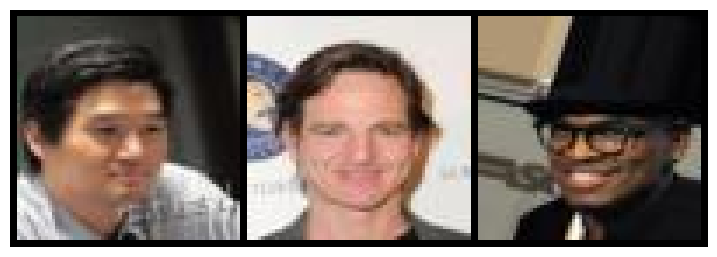

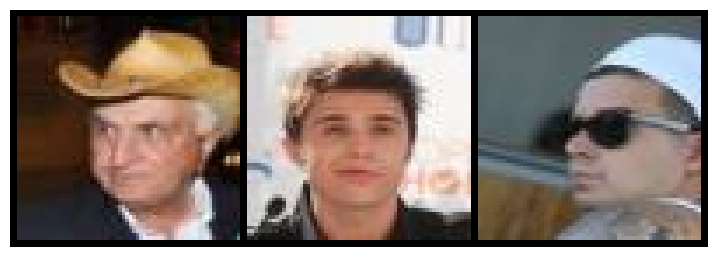

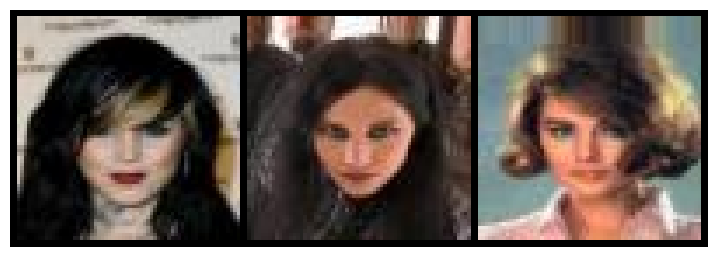

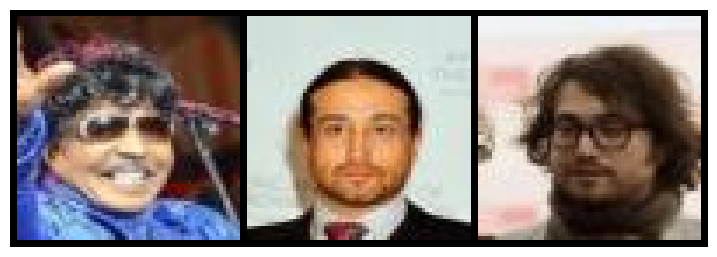

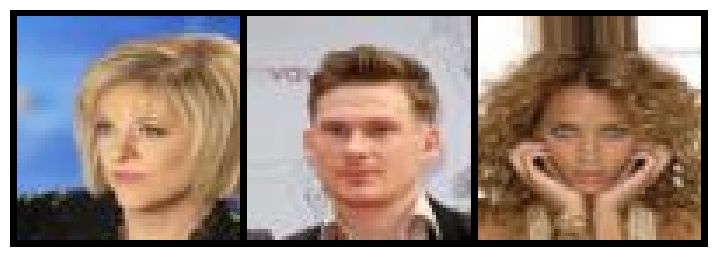

In [19]:
imgtemp = []
for i in men_smiling_ix:
    imgtemp.append(dataset[i][0].unsqueeze(0).to(device))

display_img_ms = torch.cat((imgtemp[0] , imgtemp[1] , imgtemp[2]), dim = 0)
display_images(display_img_ms , figsize=(9,9))


imgtemp = []
for i in people_hat_ix:
    imgtemp.append(dataset[i][0].unsqueeze(0).to(device))

display_img_ph = torch.cat((imgtemp[0] , imgtemp[1] , imgtemp[2]), dim = 0)
display_images(display_img_ph , figsize=(9,9))


imgtemp = []
for i in people_no_hat_ix:
    imgtemp.append(dataset[i][0].unsqueeze(0).to(device))

display_img_pnh = torch.cat((imgtemp[0] , imgtemp[1] , imgtemp[2]), dim = 0)
display_images(display_img_pnh , figsize=(9,9))


imgtemp = []
for i in people_mustache_ix:
    imgtemp.append(dataset[i][0].unsqueeze(0).to(device))

display_img_pm = torch.cat((imgtemp[0] , imgtemp[1] , imgtemp[2]), dim = 0)
display_images(display_img_pm , figsize=(9,9))

imgtemp = []
for i in people_no_mustache_ix:
    imgtemp.append(dataset[i][0].unsqueeze(0).to(device))

display_img_pnm = torch.cat((imgtemp[0] , imgtemp[1] , imgtemp[2]), dim = 0)
display_images(display_img_pnm , figsize=(9,9))

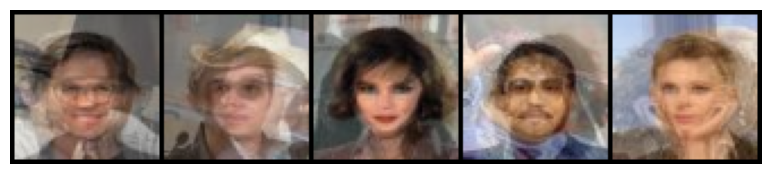

In [20]:
ms_mean = (display_img_ms[0] + display_img_ms[1] + display_img_ms[2]) / 3
ph_mean = (display_img_ph[0] + display_img_ph[1] + display_img_ph[2]) / 3
pnh_mean = (display_img_pnh[0] + display_img_pnh[1] + display_img_pnh[2]) / 3
pm_mean = (display_img_pm[0] + display_img_pm[1] + display_img_pm[2]) / 3
pnm_mean = (display_img_pnm[0] + display_img_pnm[1] + display_img_pnm[2]) / 3

disp = torch.cat((ms_mean.unsqueeze(0) , ph_mean.unsqueeze(0) , pnh_mean.unsqueeze(0) , pm_mean.unsqueeze(0) , pnm_mean.unsqueeze(0)), dim = 0)

display_images(disp , figsize=(10,2))

In [21]:
# a = (encoder(display_img_pnm))
# b = a[0] + a[1] + a[2]
# display_images(model(b.view(-1 , 100 , 1 , 1)).view(-1 , 3, 64, 64) , figsize=(2,2))

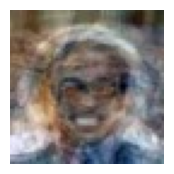

In [22]:
tot_mean = (ms_mean + ph_mean - pnh_mean + pm_mean - pnm_mean)
display_images(tot_mean.unsqueeze(0) , figsize=(2,2))

In [23]:
display_img_ms_latent = encoder(display_img_ms)
display_img_ph_latent = encoder(display_img_ph)
display_img_pnh_latent = encoder(display_img_pnh)
display_img_pm_latent = encoder(display_img_pm)
display_img_pnm_latent = encoder(display_img_pnm)

display_img_ms_latent_mean = (display_img_ms_latent[0] + display_img_ms_latent[1] + display_img_ms_latent[2]) / 3
display_img_ph_latent_mean = (display_img_ph_latent[0] + display_img_ph_latent[1] + display_img_ph_latent[2]) / 3
display_img_pnh_latent_mean = (display_img_pnh_latent[0] + display_img_pnh_latent[1] + display_img_pnh_latent[2]) / 3
display_img_pm_latent_mean = (display_img_pm_latent[0] + display_img_pm_latent[1] + display_img_pm_latent[2]) / 3
display_img_pnm_latent_mean = (display_img_pnm_latent[0] + display_img_pnm_latent[1] + display_img_pnm_latent[2]) / 3

disp_latent = torch.cat((display_img_ms_latent_mean.unsqueeze(0) , display_img_ph_latent_mean.unsqueeze(0) , display_img_pnh_latent_mean.unsqueeze(0) , display_img_pm_latent_mean.unsqueeze(0) , display_img_pnm_latent_mean.unsqueeze(0)), dim = 0)


c:\Users\aryan\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


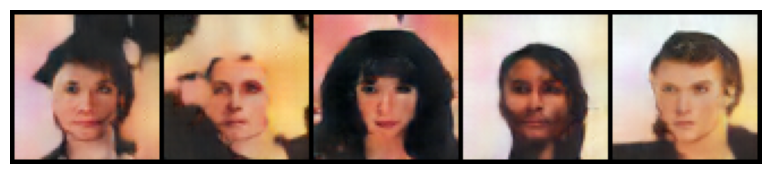

In [24]:
display_images(model(disp_latent) , figsize=(10,2))

In [25]:
final_disp_latent = display_img_ms_latent_mean + display_img_ph_latent_mean - display_img_pnh_latent_mean + display_img_pm_latent_mean - display_img_pnm_latent_mean
final_disp = model(final_disp_latent.view(-1 , 100, 1, 1))

In [26]:
noise = torch.randn(8 , 100, 1, 1) * 0.25
noise = torch.cat((noise , torch.zeros(1 , 100, 1 , 1)) , dim = 0).to(device)

final_disp_grid = torch.cat(tuple([final_disp_latent for i in range(9)]) , dim = 0).view(-1 , 100 , 1 , 1)

final_disp_grid = final_disp_grid + noise

final_disp_grid = model(final_disp_grid)

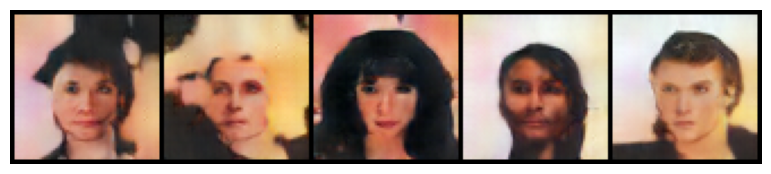

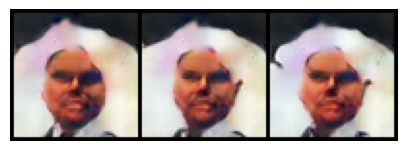

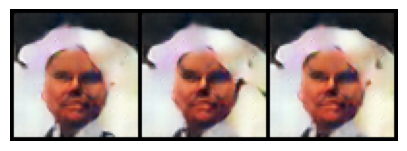

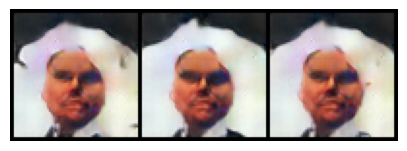

In [27]:
display_images(model(disp_latent) , figsize=(10,2))
display_images(final_disp_grid[:3] , figsize=(5,5))
display_images(final_disp_grid[3:6] , figsize=(5,5))
display_images(final_disp_grid[6:] , figsize=(5,5))

In [28]:
# men_neutral_latent = encoder(display_img_mn)
# women_neutral_latent = encoder(display_img_wn)
# women_smiling_latent = encoder(display_img_ws)

# men_neutral_mean = sum(men_neutral_latent[i] for i in range(3))/3
# women_neutral_mean = sum(women_neutral_latent[i] for i in range(3))/3
# women_smiling_mean = sum(women_smiling_latent[i] for i in range(3))/3

In [29]:
# print("-------------------------Images--------------------------------------" , "-------mean--------")

# dis_wn = torch.cat( (display_img_wn, model(women_neutral_mean.view(-1,100,1,1)) ), dim = 0)
# dis_ws = torch.cat( (display_img_ws , model(women_smiling_mean.view(-1 , 100, 1 ,1))), dim = 0)
# dis_mn = torch.cat( (display_img_mn , model(men_neutral_mean.view(-1 , 100, 1 ,1))), dim = 0)
# display_images(dis_ws , figsize=(9,9))
# # print("Women Neutral")
# display_images(dis_mn , figsize=(9,9))
# # print("Women smiling")
# display_images(dis_wn , figsize=(9,9))
# # print("Men Neutral")

In [30]:
# print("-------------------------Images--------------------------------------" , "-------mean--------")
# mean_wn = (display_img_wn[0] + display_img_wn[1] + display_img_wn[2])/3
# mean_ws = (display_img_ws[0] + display_img_ws[1] + display_img_ws[2])/3
# mean_mn = (display_img_mn[0] + display_img_mn[1] + display_img_mn[2])/3


# dis_wn = torch.cat( (display_img_wn, mean_wn.view(-1,3,64,64) ), dim = 0)
# dis_ws = torch.cat( (display_img_ws , mean_ws.view(-1,3,64,64)), dim = 0)
# dis_mn = torch.cat( (display_img_mn , mean_mn.view(-1,3,64,64)), dim = 0)
# display_images(dis_ws , figsize=(9,9))
# # print("Women Neutral")
# display_images(dis_wn , figsize=(9,9))
# # print("Women smiling")
# display_images(dis_mn , figsize=(9,9))
# # print("Men Neutral")

In [31]:
# total = mean_wn + mean_ws - mean_mn
# display_images(total , figsize=(3,3))

In [32]:
# abc = torch.cat((dis_ws[-1] , dis_mn[-1] , dis_wn[-1]) , dim = 0)
# display_images(abc.view(3,3,64,64) , figsize=(9,9))

In [33]:
# man_smiling =  women_smiling_mean + women_neutral_mean - men_neutral_mean  
# # man_smiling_img = model(man_smiling.view(-1,100,1,1))

# man_smiling_9grid = torch.cat(tuple([man_smiling for i in range(9)])).view(9, 100, 1, 1)

# noise = torch.randn(8, 100,1, 1, device=device) * 0.25
# noise = torch.cat((noise, torch.zeros(1, 100, 1,1, device = device)))

# man_smiling_9grid = man_smiling_9grid + noise

# disp_now = model(man_smiling_9grid.view(-1,100,1,1))

# display_images(disp_now[:3], figsize = (5,5))
# display_images(disp_now[3:6], figsize = (5,5))
# display_images(disp_now[6:], figsize = (5,5))